# Building the Neural Network

## Library Imports

In [1]:
#### KERAS IMPORTS ####
from keras import backend as K
K.set_image_dim_ordering('tf')

import keras
from keras.models import Sequential
from keras import layers
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model

#### OTHER IMPORTS ####
import cv2
import numpy as np
import pandas as pd
import os
import re
import datetime
import shutil
import uuid
from sklearn.metrics.pairwise import cosine_similarity
import imageio

# from PIL import ImageGrab
import matplotlib.pyplot as plt
from IPython.display import clear_output

% pylab inline
% matplotlib inline

print("BACKEND: ", keras.backend.backend())

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
BACKEND:  tensorflow


## Functions

In [9]:
def resize_img(orig_img, new_dim):
    '''
    DESCRIPTION:
        - resizes the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - new_dim is the base number of pixels for the new image.
    OUTPUT:
        - resized is a numpy array of the resized image.
    '''
    r = float(new_dim) / orig_img.shape[1]
    dim = (new_dim, int(orig_img.shape[0] * r))
    resized = cv2.resize(orig_img, dim, interpolation=cv2.INTER_AREA)
    
    return resized

In [10]:
def rotate_img(orig_img, deg_rot, scale):
    '''
    DESCRIPTION:
        - rotates the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - scale (btwn 0 and 1) zooms in on the image. scale (> 1) zooms out on the image. 
        - scale can be used to crop the image based only on the center.
    OUTPUT:
        - rotated_img is a numpy array of the rotated image.
    '''
    (height, width) = orig_img.shape[:2]
    center = (width/2, height/2)
    matrix = cv2.getRotationMatrix2D(center,
                                     angle=deg_rot,
                                     scale=scale)
    rotated_img = cv2.warpAffine(orig_img,
                                 matrix,
                                 (width, height))
    
    return rotated_img

In [11]:
def crop_img(orig_img, h1, h2, w1, w2):
    '''
    DESCRIPTION:
        - crops the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - h1 and h2 defines height
        - w1 and w2 defines the width
    OUTPUT:
        - cropped_img is a numpy array of the cropped image.
    '''
    cropped_img = orig_img[h1:h2, w1:w2]

    return cropped_img

In [12]:
def blur_img(orig_img, size=15):
    '''
    DESCRIPTION:
        - blurs the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - size dictates the amount of blurring
    OUTPUT:
        - blurred_img is a numpy array of the blurred image.
    '''
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    
    blurred_img = cv2.filter2D(orig_img, -1, kernel_motion_blur)
    
    return blurred_img

In [ ]:
def augment(image_path, new_path, repeat=5):
    '''
    DESCRIPTION:
        - randomly augments the image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - repeat is an integer value stating the number of augmented images per clean image.
        - new_path is the relative directory to save the augmented images to.
    OUTPUT:
        - new_img is a numpy array of the augmented image.
    '''    
    img_arr = cv2.imread(image_path)
    
    img_paths = []
    
    for _ in range(repeat):
        if img_arr is None:
            continue
        blurred_arr = blur_img(img_arr, size=np.random.randint(10,30))

        deg = np.random.randint(15, 345)
        scale = np.random.uniform(low=1, high=3)
        new_img_arr = rotate_img(blurred_arr, deg, scale)
        
        if new_img_arr.shape[0] <= 100 or new_img_arr.shape[1] <= 100:
            lower_height = new_img_arr.shape[0] - 1
            lower_width = new_img_arr.shape[1] - 1
        else:
            lower_height = np.random.randint(100, new_img_arr.shape[0])
            lower_width = np.random.randint(100, new_img_arr.shape[1])
        upper_height = np.random.randint(lower_height, 10000)
        upper_width = np.random.randint(lower_width, 10000)
        
        cropped_arr = crop_img(new_img_arr, h1=lower_height, h2=upper_height, w1=lower_width, w2=upper_width)
        
        if not os.path.isdir(new_path):
            os.makedirs(new_path)
            print("Created {} directory".format(new_path))
            
        cropped_img_path = os.path.join(new_path, str(uuid.uuid4()) + '.jpg')
        cropped_img = cv2.imwrite(cropped_img_path, cropped_arr)
        
        if not cropped_img:
            print("Check image path: ", cropped_img_path)
            if os.path.isfile(cropped_img_path):
                os.remove(cropped_img_path)
            continue
        img_paths.append(cropped_img_path)
    
    return img_paths

In [ ]:
def get_files(paths, with_augment=False, aug_file_path=None):
    '''
    DESCRIPTION:
        - Generates the list of image file paths.
    INPUT:
        - paths is an iterable object with valid directories.
        - If augment is True, then the images in the paths are augmented.
            - aug_file_path must also be specified.
    OUTPUT:
        - If augment is True, then clean_files is a list of clean image file paths 
          and aug_files is a list of augmented file paths.
        - If augment is False, then only one list of file paths are given.
    '''
    clean_files = []
    for path in paths:
        if os.path.isdir(path):
            clean_files += [path + f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        else:
            print("{} is invalid.".format(path))
            
    if with_augment:
        if aug_file_path:
            if not os.path.isdir(aug_file_path):
                os.makedirs(aug_file_path)
            aug_files = []
            for item in clean_files:
                aug_img = augment(item, repeat=5, new_path=aug_file_path)
                
            aug_files = [aug_file_path + f for f in os.listdir(aug_file_path) if os.path.isfile(os.path.join(aug_file_path, f))]
            return clean_files, aug_files
    else:
        print("Enter in a directory to save augmented images.")
        return clean_files

In [ ]:
def move_files(file_paths, perc_list, dir_list):
    '''
    DESCRIPTION:
        - Moves files to specific directories.
    INPUT:
        - file_paths is an iterable object with valid file paths.
        - perc_list is an iterable object with floats that sum to 1.
        - dir_list
    OUTPUT:
        - If augment is True, then clean_files is a list of clean image file paths 
          and aug_files is a list of augmented file paths.
        - If augment is False, then only one list of file paths are given.
    '''
    if len(perc_list) > len(dir_list):
        print("Warning: more percentages ({}) than available directories ({})".format(len(perc_list, len(dir_list))))
    
    if len(perc_list) < len(dir_list):
        print("Error: Too few percentages.")
        return False
    
    for i, d in enumerate(dir_list):
        if not os.path.isdir(d):
            os.makedirs(d)
        
        num_files = int(len(file_paths) * perc_list[i]) - 1
        count = 0
        cycle_count = 0
        for f in file_paths:
            if os.path.isfile(f):
                shutil.move(f, d)
                count += 1
                
            if count == num_files:
                break
    return True

In [ ]:
def get_generators(train_dir, test_dir, rescale=False, image_gen=None):
    '''
    DESCRIPTION:
        - Creates the data generators for the model.
    INPUT:
        - If the training data needs to be augmented with more data, then set rescale to True.
        - Also, make sure to input a valid ImageDataGenerator object.
    OUTPUT:
        - train_gen and test_gen are outputted
    '''
    if not os.path.isdir(train_dir):
        print("Error: invalid train data directory.")
        return False
    
    if not os.path.isdir(test_dir):
        print("Error: invalid test data directory.")
        return False 
    
    if not rescale:
        train_datagen = image.ImageDataGenerator(rescale=1./255)
    else:
        try:
            train_gen = image_gen
        except:
            print("Please input a valid generator.")
            return False
    test_datagen = image.ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=100,
                                                  class_mode='binary')
    
    test_gen = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=100,
                                                class_mode='binary')
    
    return train_gen, test_gen

In [ ]:
def get_model(input_shape, weights='imagenet'):
    '''
    DESCRIPTION:
        - Compiles the keras VGG16 model.
    INPUT:
        - Input shape should match the backend type:
            - Tensorflow: (224,224,3)
            - Theano: (3,224,224)
    OUTPUT:
        - final_model is outputted.
    '''
    model = VGG16(include_top=False, weights=weights, input_shape=input_shape)
    last = model.output

    # Freeze convolutional layers
    for layer in model.layers:
        layer.trainable = False

    x = Dropout(0.5)(last)
    x = Flatten()(x)
    x = Dense(1)(x)
    preds = Activation(activation='sigmoid')(x)

    final_model = Model(input=model.input, output=preds)

    final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
                loss='binary_crossentropy', metrics=['accuracy'])
    
    return final_model

In [ ]:
def train_model(model, nb_epoch, generators, model_dir):
    '''
    DESCRIPTION:
        - Trains the compiled keras model,
    INPUT:
        - model is a compiled keras model.
        - nb_epoch is the number of epochs to run.
        - generators are the training and validation data generators.
        - model_dir is the directory to save the trained model and weights.
    OUTPUT:
        - the trained model is outputted.
    '''
    train_generator, validation_generator = generators
    
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        validation_data=validation_generator,
        validation_steps=10,
        epochs=nb_epoch)
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    model.save(os.path.join(model_dir, 'model.h5'))
    model.save_weights(os.path.join(model_dir,'model_weights.h5'))
    return model

In [20]:
def split_model(model):
    '''
    DESCRIPTION:
        - Splits the top layer of the model with the rest of the model.
    INPUT:
        - model should be pretrained.
    OUTPUT:
        - Returns the bottom_layers and a newly created top_layer.
    '''
    bottom_layers = model
    bottom_layers.layers.pop()
    bottom_layers.layers.pop()
    inp = bottom_layers.input
    out = bottom_layers.layers[-1].output

    bottom_layers = Model(inp, out)
    
    top_layer = Sequential()
    top_layer.add(Dropout(0.5, input_shape=bottom_layers.output_shape))
    top_layer.add(Dense(1))
    top_layer.add(Activation(activation='sigmoid'))

    top_layer.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
                loss='binary_crossentropy', metrics=['accuracy'])
    
    return bottom_layers, top_layer

In [ ]:
def get_frames(file_path, top_layer, bottom_layers, path, threshold, consecutive):
    '''
    DESCRIPTION:
        - Given a video file, this function predicts frame-by-frame if the picture is "good" or "bad".
    INPUT:
        - file_path is a valid video file. Must be a string.
        - model should be fit and able to be predicted on. Ideally should be a binary classifier for this use case.
        - consecutive should be the number of consecutive good photos the model needs to see before saving the photo.
    OUTPUT:
        - prints if the frame is good or bad.
    '''
    try:
        vid = imageio.get_reader(file_path)
    except:
        print("Invalid video file")
        return None
    
    feature_vec_list = []
    orig_frames = []
    good_frames = []
    curr_feat_vec = []
    
    frame_count = 0
    good_count = 0
    good_frames_count = 0
    
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)
        
    os.makedirs(path)

    for i in range(vid.get_length()):
        try:
            frame = vid.get_data(i)
        except:
            print("Frame could not be read.")
            continue

        resized = np.array([cv2.resize(frame, (224, 224)).astype(np.float32)])
        feat_vec = bottom_layers.predict(resized)
        if curr_feat_vec == []:
            curr_feat_vec = feat_vec

        if cosine_similarity(curr_feat_vec, feat_vec) > threshold or len(feature_vec_list) == 0:
            feature_vec_list.append(feat_vec)
            orig_frames.append(frame)
            curr_feat_vec = feat_vec
            if len(feature_vec_list) == consecutive:
                print("LENGTH OF CURRENT SCENE (CONSECUTIVE): {}".format(len(feature_vec_list)))
                pred = top_layer.predict(np.array(feature_vec_list))

                file_path = os.path.join(path, str(good_frames_count) + "_" + str(uuid.uuid4()) + '.jpg')
                cv2.imwrite(file_path, orig_frames[np.argmax(pred)])
                good_frames.append(orig_frames[np.argmax(pred)])
                good_frames_count += 1

                pred = np.delete(pred, np.argmax(pred))
                print("File Path: {}".format(file_path))
                feature_vec_list = []
                orig_frames = []
        else:
            print("LENGTH OF CURRENT SCENE (CHANGE): {}".format(len(feature_vec_list)))
            pred = top_layer.predict(np.array(feature_vec_list))
                
            file_path = os.path.join(path, str(good_frames_count) + "_" + str(uuid.uuid4()) + '.jpg')
            cv2.imwrite(file_path, orig_frames[np.argmax(pred)])
            good_frames.append(orig_frames[np.argmax(pred)])
            good_frames_count += 1

            pred = np.delete(pred, np.argmax(pred))
            print("File Path: {}".format(file_path))

            feature_vec_list = []
            orig_frames = []

    print("Good Frames Count: {}".format(good_frames_count))

    return good_frames

In [ ]:
def show_images_from_folder(folder):
    images = []
    if not os.path.isdir(folder):
        os.makedirs(folder)
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
def get_bad_frames(file_path, top_layer, bottom_layers, path, threshold, consecutive):
    '''
    DESCRIPTION:
        - Given a video file, this function predicts frame-by-frame if the picture is "good" or "bad".
    INPUT:
        - file_path is a valid video file. Must be a string.
        - model should be fit and able to be predicted on. Ideally should be a binary classifier for this use case.
        - consecutive should be the number of consecutive good photos the model needs to see before saving the photo.
    OUTPUT:
        - prints if the frame is good or bad.
    '''
    try:
        vid = imageio.get_reader(file_path)
    except:
        print("Invalid video file")
        return None
    
    feature_vec_list = []
    orig_frames = []
    good_frames = []
    curr_feat_vec = []
    
    frame_count = 0
    good_count = 0
    good_frames_count = 0
    
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)
        
    os.makedirs(path)

    for i in range(vid.get_length()):
        try:
            frame = vid.get_data(i)
        except:
            print("Frame could not be read.")
            continue

        resized = np.array([cv2.resize(frame, (224, 224)).astype(np.float32)])
        feat_vec = bottom_layers.predict(resized)
        if curr_feat_vec == []:
            curr_feat_vec = feat_vec

        if cosine_similarity(curr_feat_vec, feat_vec) > threshold or len(feature_vec_list) == 0:
            feature_vec_list.append(feat_vec)
            orig_frames.append(frame)
            curr_feat_vec = feat_vec
            if len(feature_vec_list) == consecutive:
                print("LENGTH OF CURRENT SCENE (CONSECUTIVE): {}".format(len(feature_vec_list)))
                pred = top_layer.predict(np.array(feature_vec_list))

                file_path = os.path.join(path, str(good_frames_count) + "_" + str(uuid.uuid4()) + '.jpg')
                cv2.imwrite(file_path, orig_frames[np.argmin(pred)])
                good_frames.append(orig_frames[np.argmin(pred)])
                good_frames_count += 1

                pred = np.delete(pred, np.argmin(pred))
                print("File Path: {}".format(file_path))
                feature_vec_list = []
                orig_frames = []
        else:
            print("LENGTH OF CURRENT SCENE (CHANGE): {}".format(len(feature_vec_list)))
            pred = top_layer.predict(np.array(feature_vec_list))
                
            file_path = os.path.join(path, str(good_frames_count) + "_" + str(uuid.uuid4()) + '.jpg')
            cv2.imwrite(file_path, orig_frames[np.argmin(pred)])
            good_frames.append(orig_frames[np.argmin(pred)])
            good_frames_count += 1

            pred = np.delete(pred, np.argmin(pred))
            print("File Path: {}".format(file_path))

            feature_vec_list = []
            orig_frames = []

    print("Good Frames Count: {}".format(good_frames_count))

    return good_frames

### Preprocessing the data

In [ ]:
# instagram-scraper humansofny, humansofamsterdam, officialhumansofbombay, humansofnewtown, humansofpdx, humansofseoul

# instagram-scraper earthpix, beautifuldestinations, vsco

# instagram-scraper citiesofmyworld, beautifullpllaces, wonderful_places

In [ ]:
clean_files, aug_files = get_files(['data/earthpix/',
                                    'data/beautifuldestinations/',
                                    'data/vsco/',
                                    'data/humansofamsterdam/',
                                    'data/officialhumansofbombay/',
                                    'data/humansofnewtown/',
                                    'data/humansofny/',
                                    'data/humansofpdx/',
                                    'data/humansofseoul/',
                                    'data/citiesofmyworld/',
                                    'data/beautifullpllaces/',
                                    'data/wonderful_places/'],
                                    with_augment=True,
                                    aug_file_path='data/aug_images/'
                                  )

### Split 70% of images to training data, 20% of images to test data, and 10% of images to holdout

In [ ]:
clean_data_dir = ['data/train_data/clean/','data/test_data/clean/','data/holdout_data/clean/']
aug_data_dir = ['data/train_data/aug/','data/test_data/aug/','data/holdout_data/aug/']

In [ ]:
success_clean = move_files(clean_files,
                           [0.7,0.2,0.1],
                           clean_data_dir)

success_aug = move_files(aug_files,
                         [0.7,0.2,0.1],
                         aug_data_dir)

### Turn images into an image generator

In [ ]:
generators = get_generators(rescale=False, 
                            image_gen=None, 
                            train_dir='data/train_data', 
                            test_dir='data/test_data')

### Train the model

In [ ]:
model = get_model(input_shape=(224,224,3))
fit_model = train_model(model,
                        nb_epoch=15,
                        generators=generators,
                        model_dir='data')

## Video Processing

### Split model into top layer and other layers

In [18]:
model=keras.models.load_model('data/model.h5')
model.layers

In [21]:
bot, top = split_model(model=keras.models.load_model('data/model.h5'))

In [23]:
top.layers

In [ ]:
print("BEFORE GET_FRAMES: ")
print(datetime.datetime.now())

In [ ]:
snap = get_frames("data/steph.mp4",
                  top_layer=top,
                  bottom_layers=bot,
                  path='data/good_photos/steph/',
                  threshold=0.17,
                  consecutive=500)
print("AFTER GET_FRAMES: ")
print(datetime.datetime.now())

In [ ]:
snap = show_images_from_folder('data/good_photos/steph/')

In [ ]:
for img in snap:
    plt.figure()
    plt.imshow(img)

In [ ]:
snap_bad = get_bad_frames("data/steph.mp4",
                  top_layer=top,
                  bottom_layers=bot,
                  path='data/good_photos/steph_bad',
                  threshold=0.17,
                  consecutive=500)
print("AFTER GET_FRAMES: ")
print(datetime.datetime.now())

In [ ]:
snap_bad = show_images_from_folder('data/good_photos/steph_bad/')

In [ ]:
for img in snap_bad:
    plt.figure()
    plt.imshow(img)

In [7]:
model = keras.models.load_model('data/model.h5')

In [5]:
img1 = image.load_img('data/good1.jpg', target_size=(224,224,3))
img1_arr = np.array([image.img_to_array(img1)])

img1_blur = blur_img(img1_arr)

print("IMAGE SHAPE: {}".format(img1_arr.shape))

IMAGE SHAPE: (1, 224, 224, 3)


In [8]:
model.predict(img1_arr)

array([[ 1.]], dtype=float32)

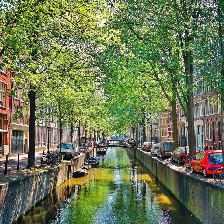

In [3]:
img1

In [16]:
l = [1,4,5,6]
l.insert(1,2)
l.insert(2,3)

In [17]:
l

[1, 2, 3, 4, 5, 6]